# O, X, Δ 을 그림판에 여러가지 이미지를 저장 후 CNN으로 학습을 시켜 데이터를 분류 하는 모델을 만들어보자.

# **1. 데이터셋 로드 및 전처리**

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [3]:
data_dir = '/content/drive/MyDrive/KDT/6. 머신러닝과 딥러닝/Data/dataset'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [109]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [110]:
dataset = datasets.ImageFolder(data_dir, transform=transform)

In [111]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = random_split(dataset, [train_size, test_size])

In [112]:
print(train_data, test_data)

<torch.utils.data.dataset.Subset object at 0x7b48dbed0b50> <torch.utils.data.dataset.Subset object at 0x7b48dbed32b0>


In [113]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

In [114]:
print(train_loader, test_loader)

<torch.utils.data.dataloader.DataLoader object at 0x7b48dbed3850> <torch.utils.data.dataloader.DataLoader object at 0x7b48dbed1a50>


# **2. CNN 모델 정의**

In [151]:
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(32, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Conv2d(64, 64, kernel_size=3, padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),

    nn.Flatten(),
    nn.Linear(64 * 8 * 8, 64),
    nn.ReLU(),
    nn.Linear(64, 3)
).to(device)

In [141]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=4096, out_features=64, bias=True)
  (11): ReLU()
  (12): Linear(in_features=64, out_features=3, bias=True)
)


# 3. **모델 학습**

In [142]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs + 1):
    sum_losses = 0
    sum_accs = 0
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        sum_losses = sum_losses + loss
        y_prob = nn.Softmax(1)(y_pred)
        y_pred_index = torch.argmax(y_prob, axis=1)
        acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
        sum_accs = sum_accs + acc


    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_loss = sum_losses / len(train_loader)
    avg_acc = sum_accs / len(train_loader)
    print(f'Epoch {epoch:4d}/{epochs} Loss: {avg_loss:.6f} Accuracy: {avg_acc:.2f}%')

Epoch    0/50 Loss: 1.119202 Accuracy: 34.93%
Epoch    1/50 Loss: 1.090266 Accuracy: 51.00%
Epoch    2/50 Loss: 1.083608 Accuracy: 37.83%
Epoch    3/50 Loss: 1.059259 Accuracy: 44.75%
Epoch    4/50 Loss: 1.003512 Accuracy: 50.11%
Epoch    5/50 Loss: 0.950085 Accuracy: 39.62%
Epoch    6/50 Loss: 0.832476 Accuracy: 62.17%
Epoch    7/50 Loss: 0.701217 Accuracy: 77.57%
Epoch    8/50 Loss: 0.570642 Accuracy: 77.79%
Epoch    9/50 Loss: 0.483757 Accuracy: 76.90%
Epoch   10/50 Loss: 0.439098 Accuracy: 79.91%
Epoch   11/50 Loss: 0.441119 Accuracy: 78.12%
Epoch   12/50 Loss: 0.411882 Accuracy: 80.80%
Epoch   13/50 Loss: 0.357761 Accuracy: 80.36%
Epoch   14/50 Loss: 0.331000 Accuracy: 84.38%
Epoch   15/50 Loss: 0.288236 Accuracy: 87.39%
Epoch   16/50 Loss: 0.261523 Accuracy: 87.61%
Epoch   17/50 Loss: 0.239511 Accuracy: 89.17%
Epoch   18/50 Loss: 0.229352 Accuracy: 92.63%
Epoch   19/50 Loss: 0.278464 Accuracy: 86.38%
Epoch   20/50 Loss: 0.201599 Accuracy: 89.51%
Epoch   21/50 Loss: 0.158847 Accur

# **4. 모델 테스트**

In [143]:
model.eval() # 모델을 테스트 모드로 전환

sum_accs = 0
test_loss = 0.0
for x_batch, y_batch in test_loader:
    x_batch = x_batch.to(device)
    y_batch = y_batch.to(device)
    y_pred = model(x_batch)
    y_prob = nn.Softmax(1)(y_pred)
    y_pred_index = torch.argmax(y_prob, axis=1)
    loss = nn.CrossEntropyLoss()(y_pred, y_batch)
    test_loss += loss.item()
    acc = (y_batch == y_pred_index).float().sum() / len(y_batch) * 100
    sum_accs = sum_accs + acc

test_loss = test_loss / len(test_loader)
test_losses.append(test_loss)
avg_acc = sum_accs / len(test_loader)
print(f'테스트 정확도는 {avg_acc:.2f}%')

테스트 정확도는 80.00%


In [152]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50
train_losses = []
test_losses = []

for epoch in range(epochs + 1):
    sum_losses = 0
    sum_accs = 0
    running_loss = 0.0

    # 모델을 학습 모드로 설정
    model.train()

    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        y_pred = model(x_batch)
        loss = nn.CrossEntropyLoss()(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        sum_losses += loss

        # 정확도 계산
        _, y_pred_class = torch.max(y_pred, 1)
        acc = (y_pred_class == y_batch).float().mean() * 100
        sum_accs += acc

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    avg_acc = sum_accs / len(train_loader)

    model.eval() # 모델을 평가 모드로 설정
    sum_accs = 0
    test_loss = 0.0

    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        # forward pass (평가 과정에서는 그래디언트 계산을 하지 않음)
        with torch.no_grad():
            y_pred = model(x_batch)
            loss = nn.CrossEntropyLoss()(y_pred, y_batch)
            test_loss += loss.item()

            # 정확도 계산
            _, y_pred_class = torch.max(y_pred, 1)
            acc = (y_pred_class == y_batch).float().mean() * 100
            sum_accs += acc

    test_loss = test_loss / len(test_loader)
    test_losses.append(test_loss)
    avg_acc = sum_accs / len(test_loader)
    print(f'테스트 정확도는 {avg_acc:.2f}%')

    print(f'Epoch {epoch:4d}/{epochs} Loss: {train_loss:.6f} Accuracy: {avg_acc:.2f}%')

테스트 정확도는 26.67%
Epoch    0/50 Loss: 1.130896 Accuracy: 26.67%
테스트 정확도는 56.67%
Epoch    1/50 Loss: 1.092588 Accuracy: 56.67%
테스트 정확도는 26.67%
Epoch    2/50 Loss: 1.082373 Accuracy: 26.67%
테스트 정확도는 26.67%
Epoch    3/50 Loss: 1.058041 Accuracy: 26.67%
테스트 정확도는 33.33%
Epoch    4/50 Loss: 1.007647 Accuracy: 33.33%
테스트 정확도는 36.67%
Epoch    5/50 Loss: 0.933123 Accuracy: 36.67%
테스트 정확도는 50.00%
Epoch    6/50 Loss: 0.856456 Accuracy: 50.00%
테스트 정확도는 73.33%
Epoch    7/50 Loss: 0.755995 Accuracy: 73.33%
테스트 정확도는 70.00%
Epoch    8/50 Loss: 0.640516 Accuracy: 70.00%
테스트 정확도는 73.33%
Epoch    9/50 Loss: 0.550187 Accuracy: 73.33%
테스트 정확도는 73.33%
Epoch   10/50 Loss: 0.471000 Accuracy: 73.33%
테스트 정확도는 66.67%
Epoch   11/50 Loss: 0.494143 Accuracy: 66.67%
테스트 정확도는 70.00%
Epoch   12/50 Loss: 0.439837 Accuracy: 70.00%
테스트 정확도는 76.67%
Epoch   13/50 Loss: 0.425991 Accuracy: 76.67%
테스트 정확도는 73.33%
Epoch   14/50 Loss: 0.402268 Accuracy: 73.33%
테스트 정확도는 63.33%
Epoch   15/50 Loss: 0.355205 Accuracy: 63.33%
테스트 정확도는

# **학습 및 테스트 손실 시각화**

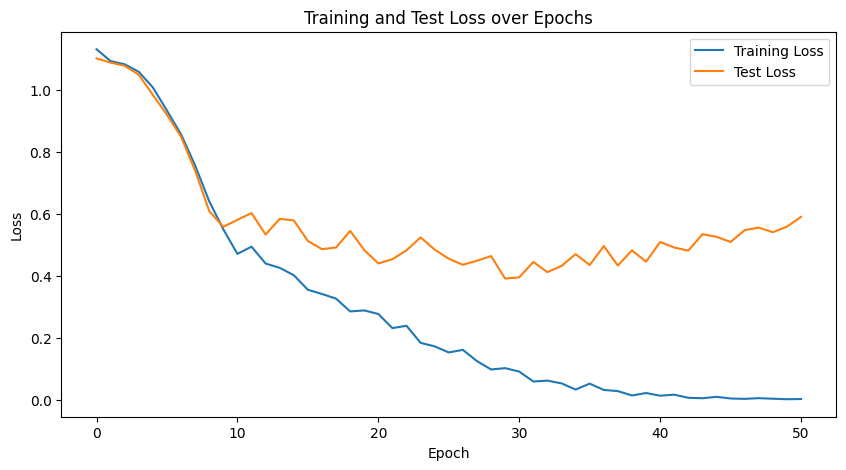

In [153]:
plt.figure(figsize=(10, 5))
plt.plot(range(epochs + 1), train_losses, label='Training Loss')
plt.plot(range(epochs + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss over Epochs')
plt.legend()
plt.show()